### Analisi e classificazione BBC news

In [38]:
# sezione di inizializazione presa dal github di A. Geron
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# TensorFlow ≥2.0 is required
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
import csv

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [39]:
# importa il dataset(CSV) usando Pandas per fare EDA
FILE_NAME = "bbc-text.csv"
df = pd.read_csv(FILE_NAME)

In [40]:
# lista di stopwords da eliminare dai testi
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", 
             "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", 
             "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", 
             "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", 
             "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", 
             "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", 
             "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", 
             "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", 
             "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", 
             "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", 
             "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", 
             "your", "yours", "yourself", "yourselves" ]

In [41]:
# function per eliminare le stopwords
def filter_stop_words(sentences, stop_words):
    for i, sentence in enumerate(sentences):
        new_sent = [word for word in sentence.split() if word not in stop_words]
        sentences[i] = ' '.join(new_sent)
    return sentences

In [42]:
# test della funzione di eliminazione delle stop words
test = ["I remember that she was not very nice and not beautiful"]
test_filtered = filter_stop_words(test, stopwords)

In [43]:
test_filtered

['I remember not nice not beautiful']

In [44]:
# esploriamo il dataset
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


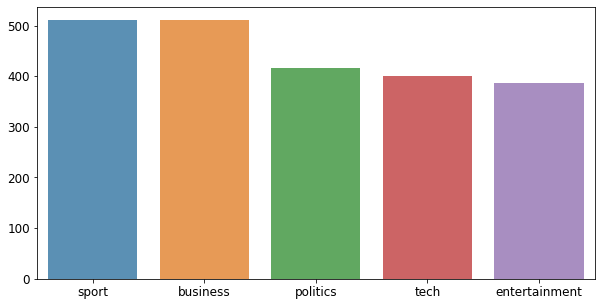

In [45]:
# vediamo la distribuzione delle categorie
category_counts = df['category'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(category_counts.index, category_counts.values, alpha=0.8)
plt.show()

In [46]:
# ci sono 5 category distinte. I testi possono essere classificati in 5 classi (sport, business, ....)

In [47]:
# carico il dataset in sentences e labels
sentences = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            # header, ignora
            line_count += 1
        else:
            # print(row[0])
            sentences.append(row[1])
            labels.append(row[0])

In [48]:
print(len(sentences))

# vediamo la seconda riga:
print(labels[1])
print(sentences[1])

2225
business
worldcom boss  left books alone  former worldcom boss bernie ebbers  who is accused of overseeing an $11bn (£5.8bn) fraud  never made accounting decisions  a witness has told jurors.  david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors.  on monday  defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination  he asked mr myers if he ever knew mr ebbers  make an accounting decision  .  not that i am aware of   mr myers replied.  did you ever know mr ebbers to make an accounting entry into worldcom books   mr weingarten pressed.  no   replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom 

In [49]:
# effettuo la rimozione delle stop words
sentences = filter_stop_words(sentences, stopwords)

In [50]:
NUM_WORDS = 5000
tokenizer = Tokenizer(oov_token = "<oov>", num_words = NUM_WORDS)
tokenizer.fit_on_texts(sentences)

In [51]:
word_index = tokenizer.word_index
print(len(word_index))

29714


In [52]:
# trasformo le frasi in sequence ed effettuo il padding
sequences = tokenizer.texts_to_sequences(sentences)

# impongo una lunghezza massima alle stringhe
max_len = 300
padded = pad_sequences(sequences, padding='post', maxlen = max_len)

padded.shape

(2225, 300)

In [53]:
# provvediamo a codificare le labels (uso sempre il tokenizer)
tokenizer_l = Tokenizer()
tokenizer_l.fit_on_texts(labels)

In [54]:
label_seq = tokenizer_l.texts_to_sequences(labels)
label_word_index = tokenizer_l.word_index

In [55]:
# print(label_seq)
print(label_word_index)

# calcola il numero di classi
NUM_CLASSI = max(label_word_index.values())

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


In [56]:
padded_label = pad_sequences(label_seq)
# porto le label nell'intervallo [0,4] (NN vogliono label che iniziano da 0) 
padded_label = padded_label - 1

In [57]:
# split in train, test
NUM_TRAIN = round(padded.shape[0] * 0.8)

train_sentences = padded[: NUM_TRAIN, :]
train_labels = padded_label[: NUM_TRAIN, :]
test_sentences = padded[NUM_TRAIN:, :]
test_labels = padded_label[NUM_TRAIN:, :]

print(train_sentences.shape)
print(test_sentences.shape)

(1780, 300)
(445, 300)


In [58]:
np.random.seed(42)
tf.random.set_seed(42)

In [59]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential

In [60]:
EMBEDDING_DIM = 12

model = Sequential()
model.add(Embedding(NUM_WORDS + 1, EMBEDDING_DIM, input_length= max_len))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(30, activation="relu"))

model.add(Dense(NUM_CLASSI, activation="softmax"))

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 12)           60012     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                108030    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 155       
Total params: 168,197
Trainable params: 168,197
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
%time history = model.fit(train_sentences, train_labels, epochs=100, batch_size=32, validation_split = 0.1, verbose=1)

Train on 1602 samples, validate on 178 samples
Epoch 1/100
1602/1602 [==============================] - 1s 408us/sample - loss: 1.5594 - accuracy: 0.2878 - val_loss: 1.5120 - val_accuracy: 0.3202
Epoch 2/100
1602/1602 [==============================] - 0s 117us/sample - loss: 1.3612 - accuracy: 0.4875 - val_loss: 1.2170 - val_accuracy: 0.6124
Epoch 3/100
1602/1602 [==============================] - 0s 115us/sample - loss: 0.7858 - accuracy: 0.8283 - val_loss: 0.5827 - val_accuracy: 0.8933
Epoch 4/100
1602/1602 [==============================] - 0s 116us/sample - loss: 0.2518 - accuracy: 0.9700 - val_loss: 0.3026 - val_accuracy: 0.9326
Epoch 5/100
1602/1602 [==============================] - 0s 114us/sample - loss: 0.0897 - accuracy: 0.9944 - val_loss: 0.2085 - val_accuracy: 0.9607
Epoch 6/100
1602/1602 [==============================] - 0s 115us/sample - loss: 0.0465 - accuracy: 0.9975 - val_loss: 0.1716 - val_accuracy: 0.9438
Epoch 7/100
1602/1602 [==============================] - 0s

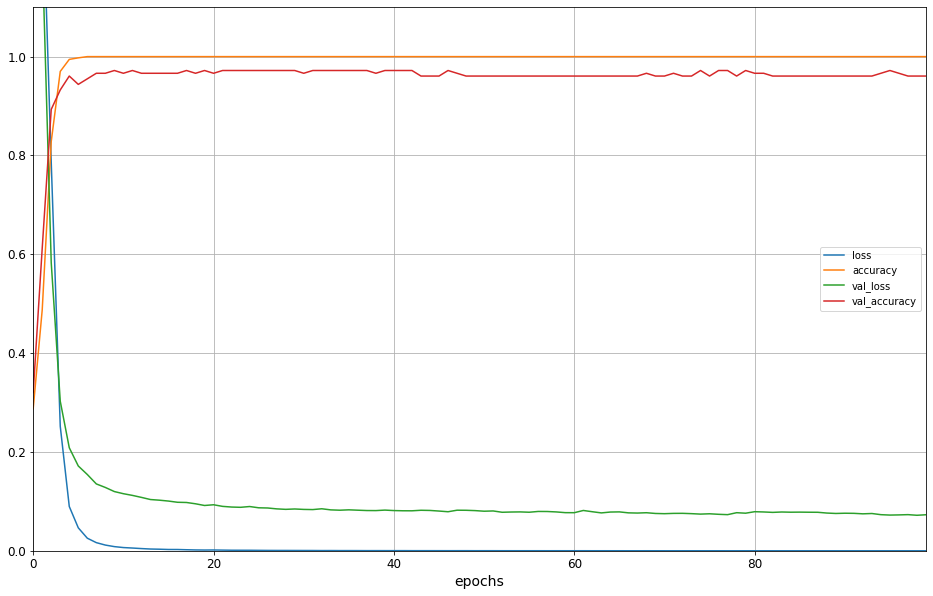

In [64]:
pd.DataFrame(history.history).plot(figsize=(16, 10))
plt.xlabel('epochs')
plt.grid(True)
plt.gca().set_ylim(0, 1.1)
plt.show()

In [65]:
loss, acc = model.evaluate(test_sentences, test_labels)

print("Accuracy su test set: %.2f" %(acc))

445/445 [==============================] - 0s 66us/sample - loss: 0.0998 - accuracy: 0.9708
Accuracy su test set: 0.97


In [66]:
# calcolo tutte le predizioni sul test set
pred = np.argmax(model.predict(test_sentences), axis = 1)

In [67]:
cm = tf.math.confusion_matrix(
    test_labels, pred, num_classes=5)

In [68]:
# la matrice di confusione
cm

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[100,   0,   0,   0,   1],
       [  0, 101,   3,   1,   1],
       [  0,   1,  82,   2,   1],
       [  1,   0,   0,  85,   0],
       [  0,   0,   1,   1,  64]], dtype=int32)>

### Testiamo su nuove frasi

In [35]:
frasi = [sentences[0], sentences[1], sentences[2], sentences[3]]

frasi = filter_stop_words(frasi, stopwords)

frasi_seq = tokenizer.texts_to_sequences(frasi)

# impongo una lunghezza massima alle stringhe
max_len = 300
frasi_padded = pad_sequences(frasi_seq, padding='post', maxlen = max_len)

frasi_padded.shape

(4, 300)

In [36]:
pred_frasi = np.argmax(model.predict(frasi_padded), axis = 1)

# riport alle originarie label
pred_frasi + 1

array([4, 2, 1, 1])

In [37]:
labels[0:4]

['tech', 'business', 'sport', 'sport']

In [ ]:
model.predict(frasi_padded)

In [ ]:
frasi